In [1]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

In [2]:
# solarized colors
solar_base03    = '#002b36' # darkest gray
solar_base02    = '#073642'
solar_base01    = '#586e75'
solar_base00    = '#657b83'
solar_base0     = '#839496' # light gray
solar_base1     = '#93a1a1' # lightest gray
solar_base2     = '#eee8d5' # dark white
solar_base3     = '#fdf6e3' # light white
solar_yellow    = '#b58900'
solar_orange    = '#cb4b16'
solar_red       = '#dc322f'
solar_magenta   = '#d33682'
solar_violet    = '#6c71c4'
solar_blue      = '#268bd2'
solar_cyan      = '#2aa198'
solar_green     = '#859900'

In [3]:
# GEM tracker colors
# done using this: https://imagecolorpicker.com/
#tracker_construction = tracker_red     = '#cb4b16'
#tracker_proposed = tracker_yellow  = '#ffb342'
#tracker_shelved = tracker_blue    = '#609ed0'
#tracker_operating = tracker_brown   = '#976f5d'
#tracker_cancelled = tracker_green   = '#93db92'
#tracker_mothballed = tracker_gray = '#515151'

In [4]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

# pipelines to map

In [5]:
# add ProjectIDs for pipelines I mention

# import data directly from google sheets

In [6]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
#spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
spreadsheet = gc.open_by_key('1IQ_g9PCr6pexDvEBoi5jboNfamJtPQ63ezxyq0qRsu0') # specific doc for briefing

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

#gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
#oil_pipes = oil_pipes.drop('WKTFormat', axis=1)

# delete columns that aren't the same in the sheets, to concatenate them...
columns_not_in_oil = list(set(gas_pipes.columns)-set(oil_pipes.columns))
columns_not_in_gas = list(set(oil_pipes.columns)-set(gas_pipes.columns))
gas_pipes.drop(columns=columns_not_in_oil, axis=1, inplace=True)
oil_pipes.drop(columns=columns_not_in_gas, axis=1, inplace=True)

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)
#pipes_df_orig = pipes_df_orig[pipes_df_orig['Status']!='N/A'] # for container rows
#pipes_df_orig = pipes_df_orig[pipes_df_orig['ProjectID']!=''] # for empty rows at bottom

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()
owners_df = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df.set_index('ProjectID', inplace=True)

In [7]:
pipes_df_orig.to_excel('pipes_df_orig.xlsx', index=False)
owners_df.to_excel('owners_df.xlsx', index=False)
country_ratios_df.to_excel('country_ratios_df.xlsx', index=False)

# for offline excel file

In [8]:
pipes_df_orig.columns

Index(['PipelineNetworkContainer', 'PipelineName', 'SegmentName', 'Wiki',
       'ProjectID', 'Fuel', 'Countries', 'Researcher', 'LastUpdated',
       'ResearcherNotes', 'Status', 'Owner', 'ProposalYear',
       'ConstructionYear', 'StartYear1', 'StartYear2', 'StartYear3', 'Delayed',
       'DelayType', 'StartYearEarliest', 'ShelvedYear', 'CancelledYear',
       'StopYear', 'ShelvedCancelledType', 'Capacity', 'CapacityUnits',
       'CapacityBcm/y', 'CapacityBOEd', 'LengthKnown', 'LengthKnownUnits',
       'LengthKnownKm', 'LengthEstimateKm', 'LengthMergedKm', 'Diameter',
       'DiameterUnits', 'FuelSource', 'StartLocation',
       'StartPrefecture/District', 'StartState/Province', 'StartCountry',
       'StartRegion', 'EndLocation', 'EndPrefecture/District',
       'EndState/Province', 'EndCountry', 'EndRegion', 'NumberOfCountries',
       'Cost', 'CostUnits', 'CostYear', 'CostType', 'CostUSD', 'FID',
       'FIDYear', 'Opposition', 'ESJNotes', 'EuropeTracker', 'PCI3', 'PCI4',
      

## replace "--" with NaN, removing empty rows

In [9]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']

In [10]:
country_ratios_df['StartYearEarliest'].replace('--', numpy.nan, inplace=True)
country_ratios_df['LengthKnownKm'].replace('--', numpy.nan, inplace=True)
country_ratios_df['CostUSD'].replace('--', numpy.nan, inplace=True)
country_ratios_df['CostUSDPerKm'].replace('--', numpy.nan, inplace=True)
country_ratios_df['LengthKnownKmByCountry'].replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [11]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [12]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [13]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [14]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

## add Total row to km by country/region

# projects by country, by region

In [86]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_country_df[status] = country_ratios_gas_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [87]:
km_by_country_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
United States,2913.14,136.75,3049.89,1681.75,24221.22,98015.09,0.0,0.00,1432.00
India,1194.00,1630.00,2824.00,0.00,1338.00,8859.33,0.0,0.00,0.00
Russia,2094.20,557.01,2651.21,0.00,541.52,40091.91,0.0,52.00,618.00
China,1046.59,1486.08,2532.67,0.00,8477.06,25271.28,0.0,0.00,6825.55
Kenya,2357.65,0.00,2357.65,0.00,1011.53,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...
Syria,0.00,0.00,0.00,0.00,0.25,0.75,0.0,426.33,171.27
San Marino,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Saudi Arabia,0.00,0.00,0.00,0.00,2.95,4873.80,0.0,1356.72,843.14
Senegal,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


# numbers of pipes finished in a given year

In [88]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Oil')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [89]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Oil')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [90]:
# indev pipelines = Proposed or Construction
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev[pipes_indev['Fuel']=='Oil']
pipes_indev = pipes_indev.groupby('Status')['LengthMergedKm'].sum()

In [91]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030[(pipes_indev_to2030['Fuel']=='Oil') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()

In [92]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Oil')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'])['LengthMergedKm'].sum()

## Fig 2 again - 2023–2030, go back to 2008

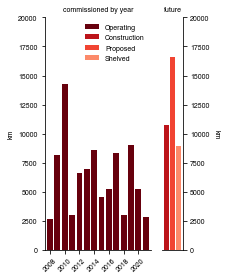

In [93]:
font_size = 7

ytop = 20000
ytop2 = 20000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

## plus/minus 8 years

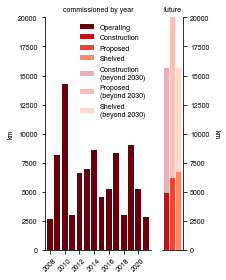

In [94]:
font_size = 7

ytop = 20000
ytop2 = 20000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
status_alt = ['Construction\n(beyond 2030)', 'Proposed\n(beyond 2030)', 'Shelved\n(beyond 2030)']
ax2_list = []

for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev_to2030[s],
             color=c, label=s))

for x,c,s,s_alt in zip(xvals,colors,status,status_alt):
    ax2_list.append(ax2.bar(x, pipes_indev[s], bottom=pipes_indev_to2030[s],
             color=c, label=s_alt, alpha=0.333))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.pdf', bbox_inches='tight', transparent=True)

## percent pipelines with start date (sanity check)

In [95]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Oil') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [96]:
pipes_scratch.shape

(107, 71)

In [97]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.6074766355140186

## regional pipelines started in given year

In [98]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [99]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Oil')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [100]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

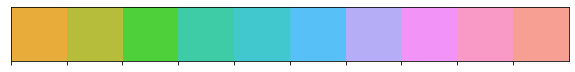

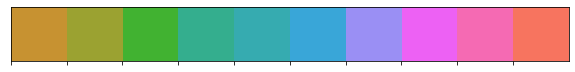

In [101]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

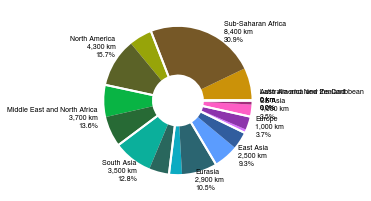

In [102]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

#mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.png', 
#           bbox_inches='tight', 
#           transparent=True,
#           dpi=600)

# top 20 countries proposed+construction

In [103]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

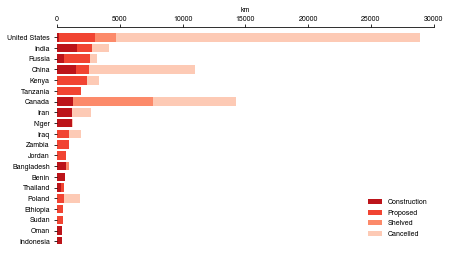

In [104]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,30000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

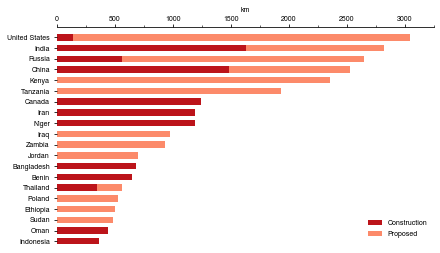

In [105]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,3250)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [106]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

0.8968378186968838

# parent analysis

In [ ]:
owner_parent_calculations_df = pandas.DataFrame()#columns=['Parent','ComboID','FractionOwnership','CapacityInMtpa'])#index=terms_df_orig.ComboID)#, columns = ['Country','Region','CapacityInMtpa'])

for idx,row in terms_df_orig.iterrows():
    #print(row.ComboID)
    parent_string = row.Parent
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
            #print(parent_list)
            #print(percent_list)
            #print()
            for p_idx,parent in enumerate(parent_list):
                owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                              pandas.DataFrame([{'Parent':parent, 'ComboID':row.ComboID, 
                                                                                 'FractionOwnership':percent_list[p_idx],
                                                                                 'CapacityInMtpa':row.CapacityInMtpa}])])
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing
            #print(percent_list)
            #print(parent_list)
            print()

    for p_idx,parent in enumerate(parent_list):
        #print(percent_list)
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ComboID':row.ComboID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'CapacityInMtpa':row.CapacityInMtpa}])])
    
    #if parent_string
    #    pass#print(parent_list)
    #else:
    #    print(parent_list)

#owner_parent_calculations_df.index.name = 'ComboID'
#owner_parent_calculations_df['Parent']
#owner_parent_calculations_df['FractionOwnership']

# emissions estimates

In [107]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed','Shelved']))&
                                     (pipes_df_orig.Fuel=='Oil')]
pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size

0.6355140186915887

In [111]:
float(pipes_df_subset['CapacityBcm/y'])

TypeError: cannot convert the series to <class 'float'>

In [ ]:
#64% of capacity data

# cost estimates (pipeline cost per km)

## looking for cost outliers

In [51]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Oil') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0)
                                   ]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [52]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

3324484.1064285715

### calculate regional costs

In [53]:
pipes_oil_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Region']==region]
    pipes_oil_costs_region_df.loc[region]['CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_oil_costs_region_df.loc[region]['NumberOfCosts'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    pipes_oil_costs_region_df.loc[region]['NumberOfLengths'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


### table for methodology with regional cost info

In [54]:
pipes_oil_costs_region_df

,CostUSDPerKm,NumberOfCosts,NumberOfLengths
Australia and New Zealand,1214335,6,6
East Asia,1868961,5,5
Eurasia,17906814,9,9
Europe,3043186,6,6
Latin America and the Caribbean,1538293,5,5
Middle East and North Africa,2117173,15,15
North America,3611851,28,28
SE Asia,938922,6,6
South Asia,1711933,5,5
Sub-Saharan Africa,3603944,6,6


### calculate country-level costs

In [55]:
#country_list_for_costs = sorted(list(set(country_ratios_with_length_and_cost_df['Country'])))
pipes_oil_costs_country_df = pandas.DataFrame(0, index=country_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for country in country_list:#_for_costs:
    #print(country)
    country_ratios_country_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Country']==country]
    pipes_oil_costs_country_df.loc[country,'CostUSDPerKm'] = country_ratios_country_df['CostUSDPerKm'].mean()
    pipes_oil_costs_country_df.loc[country,'NumberOfCosts'] = list(set(country_ratios_country_df['ProjectID'])).__len__()
    pipes_oil_costs_country_df.loc[country,'NumberOfLengths'] = list(set(country_ratios_country_df['ProjectID'])).__len__()

## table for regional totals

In [56]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Sub-Saharan Africa,6497.81,1950.00,8447.81,0.00,2100.00,8932.05,0.00,0.00,0.00
North America,2913.14,1380.88,4294.02,8090.76,30867.84,126096.14,0.00,0.00,2698.42
Middle East and North Africa,1816.74,1903.00,3719.74,0.00,3587.42,26810.56,0.00,2368.08,1214.51
South Asia,1194.00,2316.00,3510.00,249.40,1692.10,9987.18,0.00,0.00,0.00
Eurasia,2094.20,768.23,2862.43,0.00,2635.32,46616.13,0.00,52.00,618.00
East Asia,1046.59,1486.08,2532.67,0.00,8477.06,26292.25,0.00,0.00,6825.55
Europe,799.90,207.00,1006.90,0.00,8232.21,27955.13,141.55,0.00,0.00
SE Asia,240.49,715.50,955.99,306.00,0.00,2159.86,0.00,0.00,0.00
Australia and New Zealand,0.00,0.00,0.00,0.00,0.00,1878.30,0.00,0.00,187.00
Latin America and the Caribbean,0.00,0.00,0.00,262.00,3730.84,13281.02,0.00,425.00,0.00


## table for km by country

In [57]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/GOIT-km-by-country.xlsx')

## table for stranded asset calculations

In [58]:
pandas.options.display.float_format = '{:,.1f}'.format
#km_by_region_df.sort_index(inplace=True)
#indices_without_total = list(km_by_region_df.index)
#if 'Total' in indices_without_total:
#    indices_without_total.remove('Total')

capex_estimates_df = km_by_region_df.loc[region_list].multiply(pipes_oil_costs_region_df['CostUSDPerKm'].values, axis=0) / 1e9

capex_estimates_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

total = capex_estimates_df.sum(axis=0)
total.name='Total'
capex_estimates_df = capex_estimates_df.append(total)

capex_estimates_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Eurasia,37.5,13.8,51.3,0.0,47.2,834.7,0.0,0.9,11.1
Sub-Saharan Africa,23.4,7.0,30.4,0.0,7.6,32.2,0.0,0.0,0.0
North America,10.5,5.0,15.5,29.2,111.5,455.4,0.0,0.0,9.7
Middle East and North Africa,3.8,4.0,7.9,0.0,7.6,56.8,0.0,5.0,2.6
South Asia,2.0,4.0,6.0,0.4,2.9,17.1,0.0,0.0,0.0
East Asia,2.0,2.8,4.7,0.0,15.8,49.1,0.0,0.0,12.8
Europe,2.4,0.6,3.1,0.0,25.1,85.1,0.4,0.0,0.0
SE Asia,0.2,0.7,0.9,0.3,0.0,2.0,0.0,0.0,0.0
Australia and New Zealand,0.0,0.0,0.0,0.0,0.0,2.3,0.0,0.0,0.2
Latin America and the Caribbean,0.0,0.0,0.0,0.4,5.7,20.4,0.0,0.7,0.0


## print out country-level stranded assets for report discussion

## country-level table for stranded asset calculations

In [59]:
pandas.options.display.float_format = '{:,.1f}'.format
#km_by_region_df.sort_index(inplace=True)
#indices_without_total = list(km_by_region_df.index)
#if 'Total' in indices_without_total:
#    indices_without_total.remove('Total')

capex_estimates_country_df = km_by_country_df.loc[country_list].multiply(pipes_oil_costs_country_df['CostUSDPerKm'].values, axis=0) / 1e9

if 'Total' in capex_estimates_country_df.index:
    capex_estimates_country_df.drop(index='Total', inplace=True)   
    total = capex_estimates_df.sum(axis=0)
    total.name='Total'
    capex_estimates_country_df = capex_estimates_country_df.append(total)

else:
    total = capex_estimates_country_df.sum(axis=0)
    total.name='Total'
    capex_estimates_country_df = capex_estimates_country_df.append(total)

capex_estimates_country_df.sort_values('Proposed+Construction', ascending=False)

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Total,92.6,39.3,132.0,48.1,179.6,"1,645.4",0.0,4.9,43.3
Russia,56.8,15.1,71.9,0.0,14.7,"1,087.3",0.0,1.4,16.8
Poland,8.9,0.0,8.9,0.0,21.3,14.5,0.0,0.0,0.0
Canada,0.0,8.5,8.5,43.7,45.2,172.5,0.0,0.0,8.6
United States,5.9,0.3,6.1,3.4,48.7,197.2,0.0,0.0,2.9
...,...,...,...,...,...,...,...,...,...
Uruguay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Uzbekistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Western Sahara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## pie chart for stranded assets

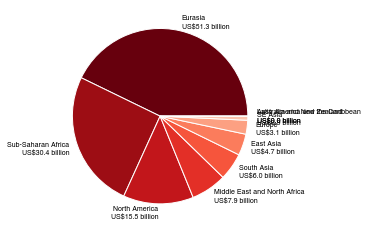

In [60]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cmap = mp.get_cmap('Reds')

pie_vals = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]
pie_labels = capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]
pie_labels_dollars = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'\nUS${x:.1f} billion')[1:]

pie_labels = [i+j for i,j in zip(pie_labels, pie_labels_dollars)]

ax.pie(pie_vals, 
       labels=pie_labels,
       colors=cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1'),
       textprops={'fontsize':font_size})

ax.tick_params(labelsize=font_size)

fig.tight_layout()

#mp.savefig('saved-figures/oil-pipelines_pie-graph.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/oil-pipelines_pie-graph.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)

mp.savefig('saved-figures/oil-pipelines_pie-graph.pdf', 
           bbox_inches='tight', 
           transparent=True)


In [61]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'US${x:.2f} billion')[1:]

Eurasia                            US$51.26 billion
Sub-Saharan Africa                 US$30.45 billion
North America                      US$15.51 billion
Middle East and North Africa        US$7.88 billion
South Asia                          US$6.01 billion
East Asia                           US$4.73 billion
Europe                              US$3.06 billion
SE Asia                             US$0.90 billion
Australia and New Zealand           US$0.00 billion
Latin America and the Caribbean     US$0.00 billion
Name: Proposed+Construction, dtype: object

In [62]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]

Eurasia                           51.3
Sub-Saharan Africa                30.4
North America                     15.5
Middle East and North Africa       7.9
South Asia                         6.0
East Asia                          4.7
Europe                             3.1
SE Asia                            0.9
Australia and New Zealand          0.0
Latin America and the Caribbean    0.0
Name: Proposed+Construction, dtype: float64

In [63]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]

Index(['Eurasia', 'Sub-Saharan Africa', 'North America',
       'Middle East and North Africa', 'South Asia', 'East Asia', 'Europe',
       'SE Asia', 'Australia and New Zealand',
       'Latin America and the Caribbean'],
      dtype='object')

### amount already being constructed

In [64]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.392494061375302

In [65]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

0.2981491140450615

# numbers for report

## km of pipeline with 2022, 2023 start years

In [66]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2022],
      pipes_indev_startyear.loc['Construction',2023])

print(pipes_indev_startyear.loc['Proposed',2022],
      pipes_indev_startyear.loc['Proposed',2023])

1289.75 1193.4
3622.74 1335.94


## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations, so we've used the regional calculation totals instead (193,365.9)

In [67]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Oil')]['LengthMergedKm'].sum()

27329.329999999998

In [68]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Oil') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [69]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

27329.559999999998

### China's percent of total

In [70]:
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df['Proposed+Construction'].sum(axis=0)

0.046335725858740504

In [71]:
km_by_country_df[:5]['Proposed+Construction'].sum(axis=0)/km_by_country_df[:-1]['Proposed+Construction'].sum(axis=0)

0.49087581358792465

In [72]:
km_by_country_df[:20]['Proposed+Construction'].sum(axis=0)/km_by_country_df[:-1]['Proposed+Construction'].sum(axis=0)

0.9440192231415362

## num in dev globally, whether capacity expansions or not

In [73]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (9, 70)
non-zero length projects: (84, 70)


In [74]:
cr = country_ratios_df.loc[(country_ratios_df.Status.isin(['Construction','Proposed']))&
                      (country_ratios_df.Fuel=='Oil')]

In [75]:
cr.loc[cr.MergedKmByPipeline!=0].groupby('ProjectID')['MergedKmByPipeline'].count()

ProjectID
P0033    1
P0358    1
P0531    1
P0538    1
P0541    2
        ..
P3864    1
P3865    1
P3877    1
P3888    1
P3889    1
Name: MergedKmByPipeline, Length: 84, dtype: int64

In [76]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])


print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

481    2,000,000
490       62,000
491       89,000
495      319,479
517      150,000
635      220,000
695       70,000
764      250,000
891          NaN
Name: CapacityBOEd, dtype: object
                 Countries CapacityBOEd
481           Saudi Arabia    2,000,000
490              Argentina       62,000
491              Argentina       89,000
495     Kazakhstan, Russia      319,479
517  Canada, United States      150,000
635          United States      220,000
695          United States       70,000
764          United States      250,000
891                  China          NaN


# texas proposed, cancelled, etc.

In [77]:
pipes_df_permian = pipes_df_orig.loc[(pipes_df_orig['StartState/Province'].isin(['Texas', 'New Mexico', 'Louisiana']))|
                                   (pipes_df_orig['EndState/Province'].isin(['Texas', 'New Mexico', 'Louisiana']))]

In [78]:
pipes_df_permian.shape

(297, 70)

## how many of in dev infra is in Texas alone?

In [79]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Proposed','Construction'])]['LengthMergedKm'].sum()

6436.94

In [80]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Proposed'])]['LengthMergedKm'].sum()

5904.65

In [81]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Construction'])]['LengthMergedKm'].sum()

532.29

In [82]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Construction'])]

,PipelineNetworkContainer,PipelineName,SegmentName,Wiki,ProjectID,Fuel,Countries,Researcher,LastUpdated,ResearcherNotes,...,Route,RouteAccuracy,RouteMapNotes,OtherEnglishNames,OtherLanguagePrimaryPipelineName,OtherLanguageAlternativePipelineNames,OtherLanguageSegmentName,OtherLanguageWikiPage,CostUSDPerKm,WKTFormat
672,,Ted Collins Link Pipeline,,https://www.gem.wiki/Ted_Collins_Link_Pipeline,P2624,Oil,United States,BL,2022/04/19,,...,"29.999574,-93.985045:29.96736,-94.016709:29.91...",,https://ir.energytransfer.com/static-files/62a...,,,,,,NaN,"LINESTRING (-93.985045 29.999574, -94.016709 2..."
756,,Keystone Port Neches Link Oil Pipeline,,https://www.gem.wiki/Keystone_Port_Neches_Link...,P3159,Oil,United States,BL,2022/04/18,,...,"29.990597280091666, -94.00310891538219 : 29.99...",,,,,,,,NaN,LINESTRING (-94.00310891538219 29.990597280091...
1105,,TransCameron Pipeline,,https://www.gem.wiki/TransCameron_Pipeline,P0269,Gas,United States,BL,08/17/2021,technically completed 2021,...,"29.767331,-92.975147:29.795517,-93.327462",,,,,,,,NaN,"LINESTRING (-92.975147 29.767331, -93.327462 2..."
1791,,Gemini Gulf Coast Pipeline,,https://www.gem.wiki/Gemini_Gulf_Coast_Pipeline,P1317,Gas,United States,BL,08/27/2021,,...,"32.206099,-94.151671:32.147816,-94.226174:32.1...",,,,,,,,NaN,"LINESTRING (-94.151671 32.206099, -94.226174 3..."
2498,,Texas Eastern Transmission (TETCO) Gas Pipeline,Cameron Expansion Project,https://www.gem.wiki/Texas_Eastern_Transmissio...,P2509,Gas,United States,JB,10/28/2021,check before update - almost complete,...,"30.44623588,-93.1436911:30.44371707,-93.157593...",,https://www.google.com/search?q=Cameron+Extens...,,,,,,NaN,"LINESTRING (-93.1436911 30.44623588, -93.15759..."
2516,,Golden Pass Gas Pipeline,,https://www.gem.wiki/Golden_Pass_Gas_Pipeline,P2539,Gas,United States,,,route from FT,...,"30.35938,-93.671875:30.301321,-93.670923:30.25...",,https://goldenpasslng.com/operations/pipeline,,,,,,NaN,"LINESTRING (-93.671875 30.35938, -93.670923 30..."
2517,,Gulf Coast Southbound Pipeline,Phase II,https://www.gem.wiki/Gulf_Coast_Southbound_Pip...,P2541,Gas,United States,BL,08/17/2021,technically completed 2021,...,Capacity expansion only,no route,https://www.kindermorgan.com/content/docs/gulf...,,,,,,NaN,NaN
2527,,Columbia Gas Transmission,Louisiana XPress Expansion Project,https://www.gem.wiki/Columbia_Gas_Transmission,P2556,Gas,United States,BL,08/25/2021,,...,Capacity expansion only,no route,,,,,,,NaN,NaN
2988,,ANR Gas Pipeline,Grand Chenier XPress Project,https://www.gem.wiki/ANR_Gas_Pipeline,P3186,Gas,United States,BL,08/25/2021,,...,Capacity expansion only,no route,,,,,,,NaN,NaN
3039,,Florida Gas Transmission Pipeline,Galveston County Project,https://www.gem.wiki/Florida_Gas_Transmission_...,P3242,Gas,United States,BL,08/17/2021,"small, route not a priority; technically compl...",...,Short route (< 100 km),no route,,,,,,,NaN,NaN


# China pipelines 

In [84]:
# Shandong Oil Pipeline Network

In [88]:
pipes_shandong = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
              (pipes_df_orig.PipelineNetworkContainer.isin(['Shandong Oil Pipeline Network']))]
pipes_northeast = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
              (pipes_df_orig.PipelineNetworkContainer.isin(['Northeast Oil Pipeline Network']))]

In [89]:
pipes_shandong.groupby('Status')['LengthMergedKm'].sum()

Status
Cancelled        120.0
Construction     836.0
Operating      6,678.6
Proposed         456.0
Retired          799.1
Name: LengthMergedKm, dtype: float64

In [90]:
pipes_northeast.groupby('Status')['LengthMergedKm'].sum()

Status
Construction     455.2
Operating      4,810.6
Proposed           9.4
Retired        4,770.7
Name: LengthMergedKm, dtype: float64